# packages

In [51]:
import time
import investpy
# https://investpy.readthedocs.io/_info/introduction.html
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pyfolio as pf #https://quantopian.github.io/pyfolio/ - need to install from git because of dependencies errors
from alpha_vantage.timeseries import TimeSeries
import yfinance as yf #https://pypi.org/project/yfinance/#description
import edhec_risk_kit_129 as erk
import requests
from io import StringIO
from pprint import pprint
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import warnings

warnings.filterwarnings("ignore")

# admiral etfs

In [23]:
df_admiral = pickle.load(open('data/df_admiral_yf.pickle', 'rb'))

In [24]:
df_admiral.head()

Adj Close                                                       \
            2INVE.MC ACWI.PA AEEM.PA AGED.L AUCO.AS AUT.PA BNK.PA BNKE.PA   
Date                                                                        
2006-10-23       NaN     NaN     NaN    NaN     NaN    NaN    NaN     NaN   
2006-10-24       NaN     NaN     NaN    NaN     NaN    NaN    NaN     NaN   
2006-10-25       NaN     NaN     NaN    NaN     NaN    NaN    NaN     NaN   
2006-10-26       NaN     NaN     NaN    NaN     NaN    NaN    NaN     NaN   
2006-10-27       NaN     NaN     NaN    NaN     NaN    NaN    NaN     NaN   

                          ... Volume                                      \
           BRE.PA BSX.PA  ... XMEM.L XMWD.L XS2D.L XSMI.SW XSPD.L XSPU.L   
Date                      ...                                              
2006-10-23    NaN    NaN  ...    NaN    NaN    NaN     NaN    NaN    NaN   
2006-10-24    NaN    NaN  ...    NaN    NaN    NaN     NaN    NaN    NaN   
2006-10-25    NaN    NaN  ...    NaN    NaN    NaN     NaN    NaN    NaN   
2006-10-26    NaN    NaN  ...    NaN    NaN    NaN     NaN    NaN    NaN   
2006-10-27    NaN    NaN  ...    NaN    NaN    NaN     NaN    NaN    NaN   

                                        
           XSSX.L XSX6.L XUKS.L XUKX.L  
Date                                    
2006-10-23    NaN    NaN    NaN    NaN  
2006-10-24    NaN    NaN    NaN    NaN  
2006-10-25    NaN    NaN    NaN    NaN  
2006-10-26    NaN    NaN    NaN    NaN  
2006-10-27    NaN    NaN    NaN    NaN  

[5 rows x 1086 columns]

In [25]:
df_admiral = df_admiral['Adj Close']

In [26]:
df_admiral.shape

(3695, 181)

In [27]:
df_admiral.columns

Index(['2INVE.MC', 'ACWI.PA', 'AEEM.PA', 'AGED.L', 'AUCO.AS', 'AUT.PA',
       'BNK.PA', 'BNKE.PA', 'BRE.PA', 'BSX.PA',
       ...
       'XMEM.L', 'XMWD.L', 'XS2D.L', 'XSMI.SW', 'XSPD.L', 'XSPU.L', 'XSSX.L',
       'XSX6.L', 'XUKS.L', 'XUKX.L'],
      dtype='object', length=181)

## describe

In [28]:
cm = sns.color_palette("coolwarm", as_cmap=True) # https://seaborn.pydata.org/tutorial/color_palettes.html
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_admiral.describe().T.head())

,count,mean,std,min,25%,50%,75%,max
2INVE.MC,2491.0,9.230499,8.018254,2.485500,3.909500,5.920000,9.910000,40.430000
ACWI.PA,2440.0,198.318421,54.548482,97.877701,147.940952,198.952896,238.871445,324.609985
AEEM.PA,2637.0,3.507672,0.594775,2.410000,3.020000,3.352200,3.993400,5.503100
AGED.L,1147.0,336.744471,188.477465,3.410500,386.024994,437.250000,451.899994,503.000000
AUCO.AS,3204.0,24.053210,7.612850,10.960000,17.702000,22.910000,29.951251,41.660000


## % nans

In [29]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame((df_admiral.isna().sum()/df_admiral.shape[0])).style.background_gradient(cmap=cm, axis = None))

,0
2INVE.MC,0.325846
ACWI.PA,0.339648
AEEM.PA,0.286333
AGED.L,0.689581
AUCO.AS,0.132882
AUT.PA,0.850609
BNK.PA,0.086062
BNKE.PA,0.496888
BRE.PA,0.086062
BSX.PA,0.083897


## correlations

In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df_admiral_corr = df_admiral.corr()
    df_admiral_corr.to_csv('df_admiral_corr.csv')
    display(df_admiral_corr.head(20).style.background_gradient(cmap=cm, axis = None))

# pyfolio stats

In [31]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df_admiral_stats = df_admiral.apply(lambda x: pf.timeseries.perf_stats(returns = x.dropna().pct_change().dropna())).T
    display(df_admiral_stats.head(20).style.background_gradient(cmap=cm, axis = 'rows'))

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
2INVE.MC,-0.189552,-0.874652,0.443596,-0.253455,-0.201969,0.825622,-0.938523,0.955087,-0.367738,0.609302,8.035865,1.007420,-0.056334
ACWI.PA,0.128847,2.231700,0.147071,0.898113,0.387055,0.944991,-0.332890,1.180477,1.245087,-0.749445,10.786321,1.022929,-0.018005
AEEM.PA,0.046784,0.613291,0.179678,0.344907,0.133735,0.734301,-0.349828,1.063194,0.469374,-0.826164,8.981830,0.961466,-0.022391
AGED.L,-0.603452,-0.985099,0.537841,-0.171350,-0.607571,0.527767,-0.993220,0.919698,-0.185674,-21.138942,648.690519,0.945840,-0.068127
AUCO.AS,0.010655,0.144211,0.432408,0.238592,0.014459,0.082906,-0.736918,1.052316,0.357605,1.622513,59.426266,1.007985,-0.054069
AUT.PA,0.147650,0.351368,0.335056,0.579554,0.287726,0.002766,-0.513162,1.117079,0.820034,-0.343233,11.045785,1.114208,-0.041442
BNK.PA,-0.065375,-0.595765,0.315076,-0.057206,-0.083336,0.112369,-0.784471,0.989364,-0.081744,0.235059,8.488605,1.012438,-0.039767
BNKE.PA,-0.024876,-0.169500,0.304599,0.071040,-0.038921,0.481085,-0.639124,1.012920,0.098823,-0.589583,10.129253,1.002227,-0.038290
BRE.PA,0.007492,0.105158,0.367962,0.204224,0.010058,0.036526,-0.744824,1.038329,0.292527,0.142631,7.203097,0.946786,-0.046061
BSX.PA,-0.087277,-0.706635,0.225445,-0.292464,-0.103207,0.942685,-0.845655,0.948096,-0.418743,0.251172,5.646259,1.008266,-0.028665


# pyfolio stats viz

## parallel coordinates plot

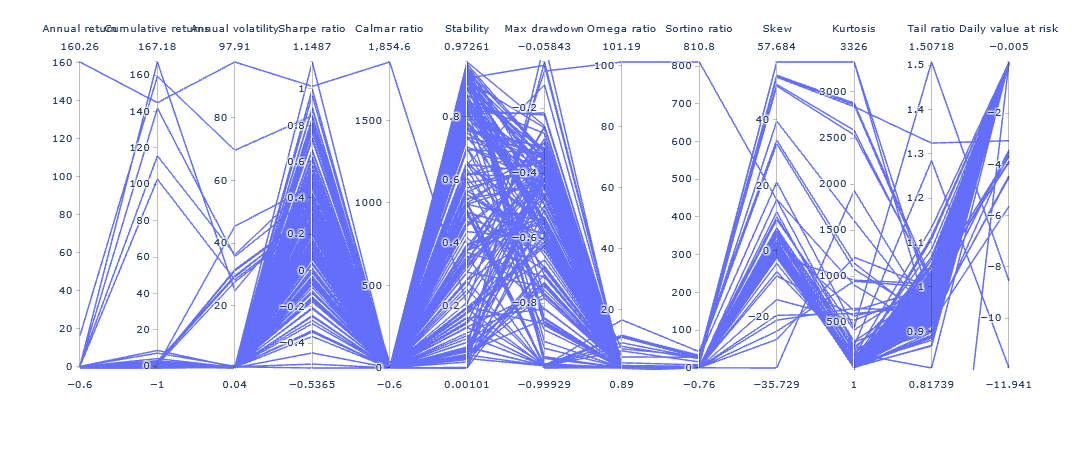

In [34]:
fig = px.parallel_coordinates(df_admiral_stats)

fig.show()

## sns pairplot

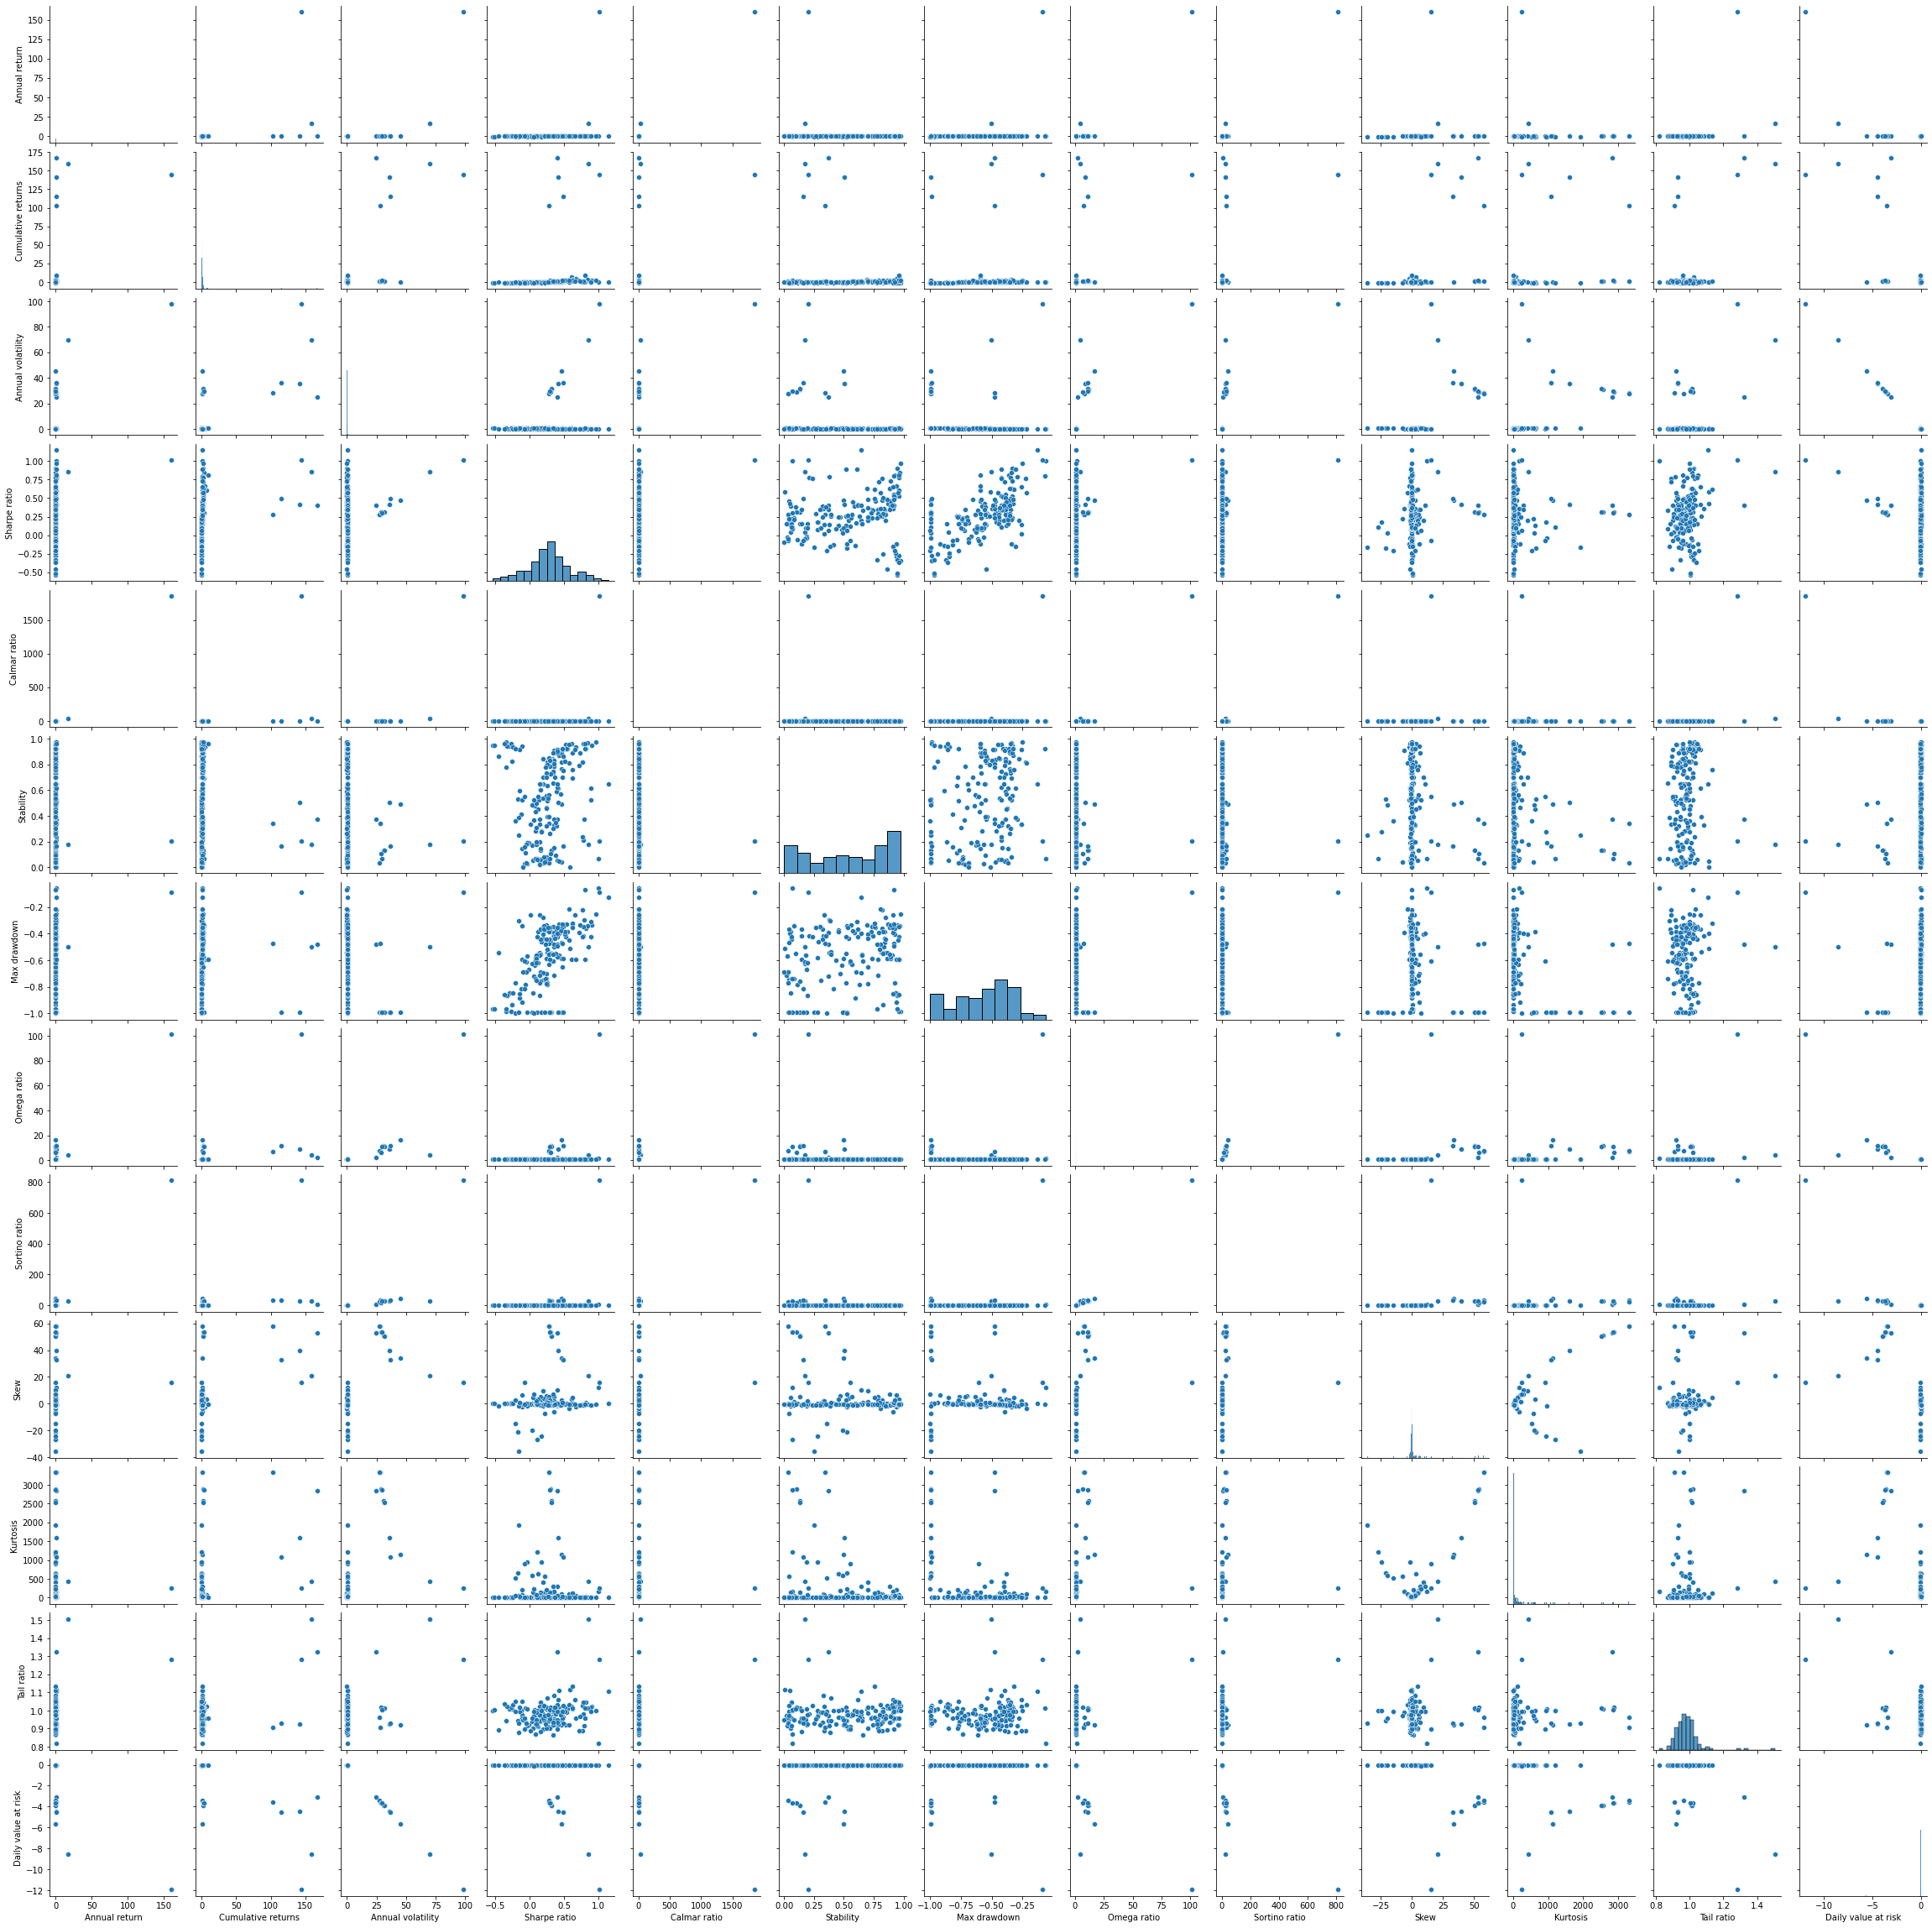

In [35]:
sns.pairplot(df_admiral_stats)

## pca

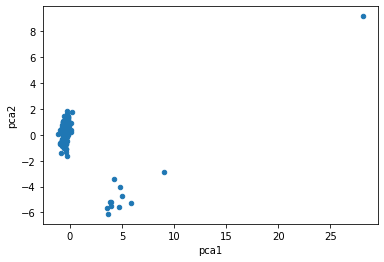

In [37]:
s_transformed = StandardScaler().fit_transform(df_admiral_stats.dropna())
pca = PCA(n_components = 2).fit(s_transformed)

t = pd.DataFrame(pca.transform(s_transformed), columns= ['pca1', 'pca2'])
t.plot.scatter(x = 'pca1', y = 'pca2')

In [39]:
pca.explained_variance_ratio_

array([0.47548571, 0.19029704])

## tsne

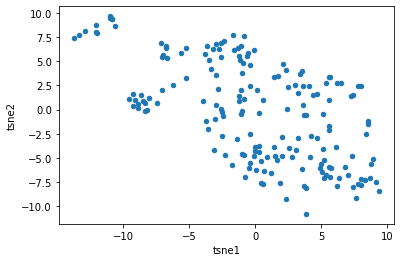

In [61]:
tsne = TSNE(n_components=2)
t = pd.DataFrame(tsne.fit_transform(s_transformed), columns= ['tsne1', 'tsne2'])
t.plot.scatter(x = 'tsne1', y = 'tsne2')